# 三、使用ORB特征匹配特征点

ORB特征点匹配方法以FAST特征点匹配为基本方法，创建了以**Oriented FAST**与**Rotated BRIEF**为核心的特征点描述与匹配方法。得到了一种可以快速提取的ORB特征，在速度方面相较于SIFT与SURF有明显的提升同时保证了特征子的旋转、尺度不变性。其改进如下：

## Oriented FAST
FAST无法体现出一个优良特征点的尺度不变性与特征不变性
- 尺度不变性：使用高斯金字塔来解决
  1. 对图像做不同尺度的高斯模糊
  2. 降采样
  3. FAST特征点检测
  4. 在图像尺度空间中所有的特征点作为图像的FAST特征点
- 方向不变性：质心标定方向来解决
  1. 在局部图像中定义图像块的矩
  2. 通过矩找到图象块的质心
  3. 连接特征点与质心得到方向向量，为特征点方向

## Rotated BRIEF
### BRIEF
经典的特征点描述子使用128维或者64维的特征向量。需求的存储空间较大，在实际运用中，可以使用PCA、LDA等特征降维方法减少特征描述子的维度，此外可以采用局部敏感哈希（Locality-Sensitive Hashing，LSH）的方法将特征描述子编码为二进制串，然后使用汉明距离进行特征点的匹配。
汉明距离：两个二进制比特串同一位置不同值的个数，通过异或操作快速实现。
BRIEF，基于二进制编码生成特征描述子，以及采用汉明距离进行特征点的匹配
- 检测特征点
- 确定特征点的领域窗口，对该领域像素点进行$\sigma=2$，窗口尺寸为9的高斯平滑，以滤除噪声
- 在领域窗口选取n对像素点，根据灰度值大小编码为二进制串（1>2?0:1）

下图为领域窗口选取的n对像素点连线，使用了不同的随机值生成方法

![](./images/ORB1.png)

### Rotated BRIEF
- 旋转不变性：依靠特征点的旋转的来
- 尺度不变性：在关键点位于的图像金字塔上进行
- 噪声敏感：不使用像素对，而是使用像素块对，以减小噪声

In [1]:
import cv2
import numpy as np
from gray_video import gray_video
import matplotlib.pyplot as plt
%matplotlib widget

In [2]:

# 计算图像特征点计算类
class OrbFeatureDetector:
    orb = cv2.ORB_create()

    def __init__(self):
        pass

    def cross_detect(self, gray1: np.ndarray, gray2: np.ndarray):
        kp1, des1 = self.orb.detectAndCompute(gray1, None)
        kp2, des2 = self.orb.detectAndCompute(gray2, None)
        # crossCheck=True，两张图的点A→B和B→A各算一次。
        bf = cv2.BFMatcher(cv2.NORM_HAMMING)
        matches = bf.knnMatch(des1, des2, k=2)

        good_matches = [[x1]
                        for x1, x2 in matches if x1.distance < 0.75*x2.distance]
        if len(good_matches) <= 8:
            return None, None, None
        # return kp1, kp2, good_matches
        count_matches = len(good_matches)
        matched_points = np.zeros((count_matches, 2, 2))
        for i in range(count_matches):
            matched_points[i][0] = kp1[good_matches[i][0].queryIdx].pt
            matched_points[i][1] = kp2[good_matches[i][0].trainIdx].pt
        return matched_points


In [3]:
orb_detector = OrbFeatureDetector()

In [4]:
i_1 = 0
i_2 = 10
result = np.zeros((gray_video[0].shape[0], gray_video[0].shape[1]*2))
result[:, :gray_video[0].shape[1]] = gray_video[i_1]
result[:, gray_video[0].shape[1]:] = gray_video[i_2]
matches_points = orb_detector.cross_detect(gray_video[i_1], gray_video[i_2])
for point_pair in matches_points:
    one_match_1_coor = np.array(point_pair[0],dtype=int)
    one_match_2_coor = np.array(point_pair[1],dtype=int)
    one_match_2_coor[0] += 1280
    cv2.circle(result, one_match_1_coor, 9, (0, 0, 255), 0)
    cv2.circle(result, one_match_2_coor, 9, (0, 0, 255), 0)
    cv2.line(result, one_match_1_coor, one_match_2_coor, (0, 0, 255))

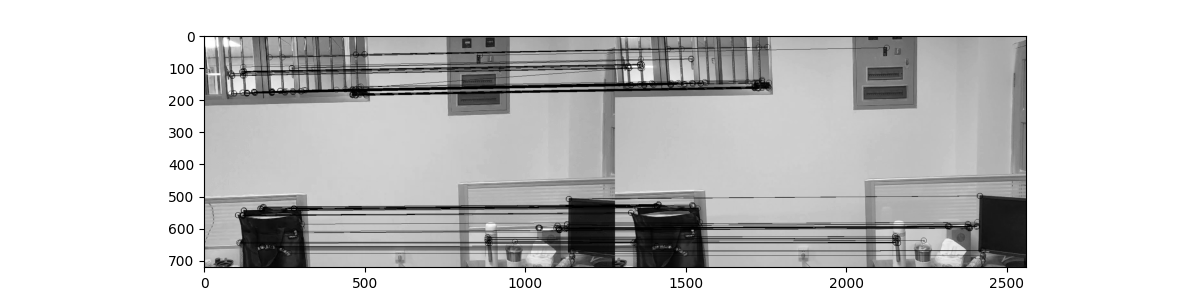

In [5]:
plt.figure(figsize=(12,3))
plt.imshow(result,'gray')
plt.show()